In [1]:
import tensorflow as tf

tf.keras.backend.clear_session()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Allow memory growth for GPU
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        


In [2]:
!pip3 install nistrng

In [15]:
from statistics import mean
import numpy as np
import h5py
import unireedsolomon as rs
from tqdm import tqdm
import matplotlib.pyplot as plt
from nistrng import *
import hashlib
import binascii
import time
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.neighbors import KNeighborsClassifier

from dataset_preparation import awgn, ChannelSpectrogram, LoadDatasetChannels
from deep_learning_models import TripletNet, TripletNet_Channel, identity_loss

def feature_quantization(features):
    mean_features = mean(features)
    threshold = mean_features #0
    features_quatized = []
    for i in features:
        if i >= threshold:
            features_quatized.append(1)
        else:
            features_quatized.append(0)
    return features_quatized  

def arr2str(arr):
    str_arr = ''
    for i in arr:
        str_arr += str(i)
    return str_arr

def str2arr(string):
    arr = []
    integer = int(string, 16)
    binary_string = format(integer, '0>42b')
    for i in binary_string:
        arr.append(int(i))
    return arr

def reconcile(A,B,n=255,k=128):
    A = hex(int(arr2str(A), 2))
    A = str(A[2:]) #A hex key
    B = hex(int(arr2str(B), 2))
    B = str(B[2:]) #B hex key
    coder = rs.RSCoder(n,k)
    Aencode = coder.encode(A) #Encode A
    Aparity = Aencode[k:] #A parity bits
    BAparity = B+Aparity #B key + A parity bits
    try:
        Bdecode = coder.decode(BAparity) #Decode B key + A parity bits
        Breconciled = Bdecode[0] #Reconcilieted key
    except:
        Breconciled = B
    return [A == Breconciled,Breconciled]

def reconciliation_rate(data,n,k):
    j = 0
    reconciliation_data1 = []
    reconciliation_data2 = []
    reconciliation_data3 = []
    reconciled_data = []
    pbar = tqdm(total = data.shape[0]/4+1)
    
    while j <= data.shape[0]-3:
        reconciliation_data1.append(reconcile(data[j],data[j+2],n,k))
        reconciliation_data2.append(reconcile(data[j],data[j+1],n,k))
        reconciliation_data3.append(reconcile(data[j+2],data[j+3],n,k))
        j = j + 4
        pbar.update(1)
        
    return reconciliation_data1, reconciliation_data2, reconciliation_data3

def privacyAmplification(data):
    # encode the string
    encoded_str = data.encode()
    # create sha3-256 hash objects
    obj_sha3_256 = hashlib.new("sha3_512", encoded_str)
    return(obj_sha3_256.hexdigest())

#https://github.com/InsaneMonster/NistRng/blob/master/benchmarks/numpy_rng_test.py
def NIST_RNG_test(data):
    #Eligible test from NIST-SP800-22r1a:
    #-monobit
    #-runs
    #-dft
    #-non_overlapping_template_matching
    #-approximate_entropy
    #-cumulative sums
    #-random_excursion
    #-random_excursion_variant
    eligible_battery: dict = check_eligibility_all_battery(np.array(data[0]), SP800_22R1A_BATTERY)
    num_packets = len(data)
    print("Eligible test from NIST-SP800-22r1a:")
    for name in eligible_battery.keys():
        print("-" + name)
    results_passed = {"Monobit" : [],"Frequency Within Block" : [],"Runs" : [],"Longest Run Ones In A Block" : [],
                      "Discrete Fourier Transform" : [],"Non Overlapping Template Matching" : [],"Serial" : [],
                      "Approximate Entropy" : [],"Cumulative Sums" : [],"Random Excursion" : [],
                      "Random Excursion Variant" : []}
    results_score = {"Monobit" : [],"Frequency Within Block" : [],"Runs" : [],"Longest Run Ones In A Block" : [],
                     "Discrete Fourier Transform" : [],"Non Overlapping Template Matching" : [],"Serial" : [],
                     "Approximate Entropy" : [],"Cumulative Sums" : [],"Random Excursion" : [],
                     "Random Excursion Variant" : []}
    data_results = []
    for i in range(0,len(data)):
        eligible_battery: dict = check_eligibility_all_battery(np.array(data[i]), SP800_22R1A_BATTERY)
        results = run_all_battery(np.array(data[i]), eligible_battery, False)
        data_results.append(results)
        for result, elapsed_time in results:
            score = np.round(result.score, 3)
            name = result.name
            results_score[name].append(score)
            if result.passed:
                passed = 1
            else:
                passed = 0
            results_passed[name].append(passed)
            
    for i in results_score:
        passing_score = sum(results_passed[i])/num_packets
        if round(passing_score) == 1:
            print("- PASSED ("+str(passing_score)+") - score: " + str(np.round(sum(results_score[i])/num_packets, 3)) + " - " + i)
        else:
            print("- FAILED ("+str(passing_score)+") - score: " + str(np.round(sum(results_score[i])/num_packets, 3)) + " - " + i)

    ith = 0
    plt.figure(figsize=[20,20])
    for i in results_passed:
        #print(results_passed[i])
        ith = ith + 1
        plt.subplot(4, 3,ith)
        plt.plot(results_passed[i])
        # naming the x axis
        plt.xlabel('N Key Generated')
        # naming the y axis
        plt.ylabel('Passed')
        plt.ylim(-0.05, 1.05)
        plt.title(i)
        
def KDR(A,B):
    kdr = np.bitwise_xor(A,B)
    kdr = np.sum(kdr)
    kdr = kdr/len(A)
    return kdr
    
def KDR_data(data):
    j = 0
    KDR_AB = []
    KDR_AC = []
    KDR_BC = []
    pbar = tqdm(total = data.shape[0]/4+1)
    while j <= data.shape[0]-3:
        KDR_AB.append(KDR(data[j],data[j+2]))
        KDR_AC.append(KDR(data[j],data[j+1]))
        KDR_BC.append(KDR(data[j+2],data[j+3]))
        j = j + 4
        pbar.update(1)
    return KDR_AB, KDR_AC, KDR_BC

In [63]:
pc = 'josea'
#pc = 'Jose Sanchez'

#FEATURE EXTRACTOR MODEL
model_path = '/Users/josea/Research/Models/'
#SINUSOID FEATURE EXTRACTOR
#feature_extractor_name = model_path+'Extractor - alpha 0.5 - batch size 40 - patience 30 - dataset_channels_dev_1-4_100.h5'
#feature_extractor_name = model_path+'Extractor_Channel_Nodes_1-4_100_quantization_layer.h5'
#feature_extractor_name = model_path+'Extractor512_alpha0.1_batchsize36_patience20_Q_KDR_DS-dev-1-4-100.h5.h5'
#feature_extractor_name = model_path+'Extractor512_alpha.4_batchsize40_LR.001_val.1_SGD.001_DS-dev1-4-100.h5'
#feature_extractor_name = model_path+'Extractor512_alpha0.1_batchsize36_patience20_DS-dev-1-4-100.h5'
#feature_extractor_name = model_path+'Extractor512_alpha.5_batchsize40_LR.001_val.1_Adam.001_DS-dev1-4-100.h5'

#feature_extractor_name = model_path+'QExtractor512_sinusoid_alpha.5_batchsize32_LR.001_val.1_RMS.001_DS-dev6789-1200.h5'
#feature_extractor_name = model_path+'QExtractor512_sin-2.4_alpha.5_batchsize32_LR.001_val.1_RMS.001_DS-dev1234-4800.h5'
#feature_extractor_name = model_path+'QExtractor512_alpha0.5_batch128_val0.1_RMS0.001_DSsin2.4dev1278-4800.h5'
#feature_extractor_name = model_path+'QExtractor.h5'
#feature_extractor_name = model_path+'QExtractor2_512_alpha0.5_batch40_val0.1_RMS0.01_DSsin2.4dev1278-2400_1710323653.130102.h5'
feature_extractor_name = model_path+'ChannelFingerprint_QExtractor_512_alpha0.5_batch40_val0.1_RMS0.001_DSsin2.4dev2578-2400_2.h5'
feature_extractor_name = model_path+'ChannelFingerprint_QExtractor_256_alpha0.5_beta0_batch64_val0.1_RMS0.001_DSsin2.4dev1278-2400_3.h5'


#feature_extractor_name = model_path+'Extractor_Channel_Nodes_1-4_100_quantization_layer_sin.h5'
#CHIRP FEATURE EXTRACTOR
#feature_extractor_name = model_path+'Extractor_Channel_Nodes_1-4_100_quantization_layer_chirp.h5'
#feature_extractor_name = model_path+'Extractor_alpha-0.3_batchsize-40_patience-30_dense-256_DS-dev-1-4-100.h5'
#feature_extractor_name = model_path+'Extractor512_chirp_alpha.5_batchsize40_LR.001_val.1_Adam.001_DS-dev1-4-100.h5'
#feature_extractor_name = model_path+'Extractor512_chirp_alpha.2_batchsize22_LR.001_val.1_RMS.001_DS-dev15789-100_2.h5'

#TESTING DATASETS
test_dataset_path = '/Users/josea/Research/Datasets/Test/'
#dataset = test_dataset_path+'Dataset_Channels_1670370545_100_Packets_Dev_123.hdf5'
#dataset = test_dataset_path+'Dataset_Channels_1669993483_100_Packets_Dev_762.hdf5'
#CHIRP DATASETS
#dataset = test_dataset_path+'Dataset_Channels_freq_915e6_sr_1e6_chirp_1e3_to_5e3_dev_123_100.hdf5'
#dataset = test_dataset_path+'Dataset_Channels_freq_915e6_sr_1e6_chirp_1e3_to_5e3_dev_785_100.hdf5'
#dataset = test_dataset_path+'Dataset_Channels_freq_915e6_sr_1e6_chirp_1e3_to_5e3_dev_789_100.hdf5'
#dataset = test_dataset_path+'Dataset_Train_Channels_chirp_Dev_178_freq_2485e9_sr_10e6_gain_0_40.hdf5'
#dataset = test_dataset_path+'Dataset_Channels_chirp_dev_581_freq_2485e9_sr_10e6.hdf5'
#Sinusoid DATASETS
#dataset = test_dataset_path+'Dataset_Channels_freq_2485e6_sr_1e6_sin_1e6_dev_123_100.hdf5'
#dataset = test_dataset_path+'Dataset_Channels_freq_2485e6_sr_1e6_sin_1e6_dev_785_100.hdf5'
#dataset = test_dataset_path+'Dataset_Channels_freq_2485e6_sr_1e6_sin_1e6_dev_789_100.hdf5'
#dataset = test_dataset_path+'Dataset_Channels_sinusoid_dev_128_freq_2.4e9_sr_1e6_gain_0_60.hdf5'

#dataset = test_dataset_path+'Dataset_Channels_sinusoid_dev_128_1690229267.hdf5'
#dataset = test_dataset_path+'Dataset_Channels_sinusoid_dev_5109_1690297117.hdf5'
#dataset = test_dataset_path+'Dataset_Channels_sinusoid_dev_871_1690302750.hdf5'

#dataset = test_dataset_path+'Dataset_Channels_sinusoid_dev_258_1694636264.hdf5'

#dataset = test_dataset_path+'Dataset_Channels_sinusoid_dev_679.hdf5'
#dataset = test_dataset_path+'Dataset_Channels_sinusoid_dev_869.hdf5'
#dataset = test_dataset_path+'Dataset_Channels_sinusoid_dev_876.hdf5'

#PN Sequence

#dataset = test_dataset_path+'Dataset_Channels_pnSequence_100_254_1710329872.hdf5'
dataset = test_dataset_path+'Dataset_Channels_pnSequence_100_782_1710328139.hdf5'

#with h5py.File(dataset, 'r') as f:
#    data = np.array(f['data'][:])

#data = np.array(data)  
#print(data[0])

In [64]:
with tf.device('/CPU:0'):
    print("loading model")
    feature_extractor = load_model(feature_extractor_name)
#feature_extractor.summary()
#plot_model(feature_extractor, to_file='featureExtractor.png', show_shapes=True, show_layer_names=True)


loading model


In [65]:
#with tf.device('/GPU:0'):
LoadDatasetObj = LoadDatasetChannels()
ChannelSpectrogramObj = ChannelSpectrogram()
# Load the classification dataset. (IQ samples and labels)
print("loading data")
data, labels = LoadDatasetObj.load_iq_samples(dataset)
print(data.shape)
#data = data[0:1]
raw_data = data

print(data[0])
# Convert IQ samples to channel independent spectrograms. (classification data)
t_start = time.time()
print("converting IQ to spectrograms")
data = ChannelSpectrogramObj.channel_spectrogram(np.array(data),256)
t_end = time.time()
print("Time for signal processing: ", t_end-t_start)

print(data.shape)
t_start = time.time()
# Extract RFFs from channel independent spectrograms.
print("extracting features")
features = feature_extractor.predict(data)
t_end = time.time()
print("Time for fingerprinting: ", t_end-t_start)
#print(features)
del data
#print(features[0])

loading data
(400, 8192)
[-0.0234375 -0.00585938j  0.03955078+0.00585938j  0.07324219+0.02197266j
 ...  0.01513672+0.05371094j -0.00439453-0.01904297j
 -0.00927734-0.05615234j]
converting IQ to spectrograms
Time for signal processing:  0.0957331657409668
(400, 102, 63, 1)
extracting features
13/13 [==============================] - 3s 174ms/step
Time for fingerprinting:  2.566728115081787


[-0.0234375   0.03955078  0.07324219 ...  0.01513672 -0.00439453
 -0.00927734]
[-0.00585938  0.00585938  0.02197266 ...  0.05371094 -0.01904297
 -0.05615234]


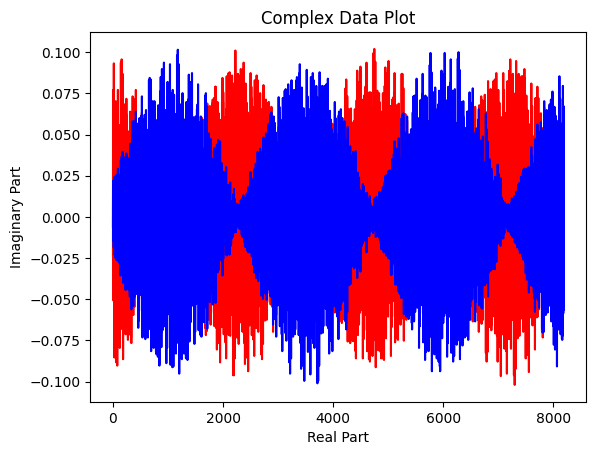

In [66]:
# Separate real and imaginary parts
real_parts = np.real(raw_data)
imaginary_parts = np.imag(raw_data)
print(real_parts[0])
print(imaginary_parts[0])
plt.plot(real_parts[0], color='red')
plt.plot(imaginary_parts[0], color='blue')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Complex Data Plot')
plt.show()

In [67]:
#feature quantization
quantized_data = []
t_start = time.time()
for i in features:
    features_quatized = feature_quantization(i)
    quantized_data.append(features_quatized)

quantized_data = np.array(quantized_data)
t_end = time.time()
print("Time for quantization: ", t_end-t_start)
print(len(quantized_data[0]))
print(len(quantized_data))

Time for quantization:  0.1961069107055664
512
400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 100/101.0 [00:00<00:00, 16066.44it/s]


Average KDR Alice-Bob: 0.1612109375
Average KDR Alice-Eve: 0.62490234375
Average KDR Bob-Eve: 0.58966796875


Text(0.5, 1.0, 'KDR Bob Eve')

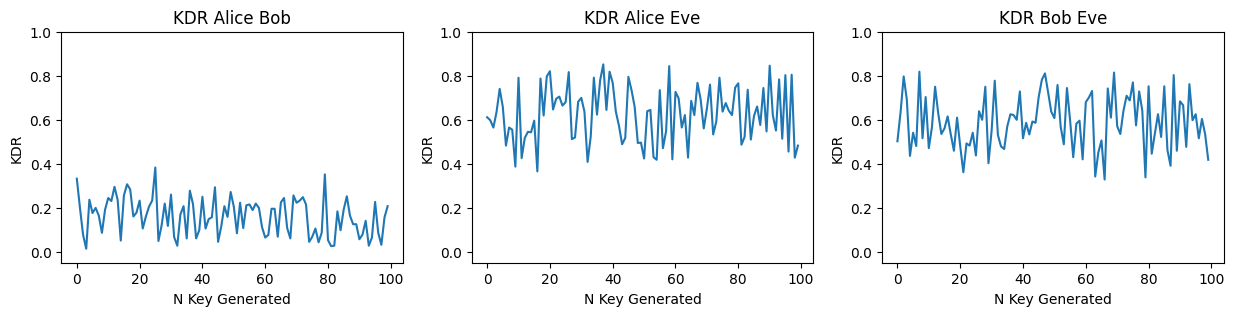

In [68]:
#Bit Dissagreement Ratio

def groupAverage(arr, n):
    result = []
    i=0
    while i <len(arr):
        sum_n = 0;
        j = 0
        while j < n:
            sum_n = sum_n + arr[i]
            j = j + 1
        result.append(sum_n/n);
        i = i + n
    return result

quantized_data = quantized_data[0:400]

KDR_AB, KDR_AC, KDR_BC = KDR_data(quantized_data)
KDR_AB_average = np.sum(KDR_AB)/(len(KDR_AB))
print("Average KDR Alice-Bob:", KDR_AB_average)
KDR_AC_average = np.sum(KDR_AC)/(len(KDR_AC))
print("Average KDR Alice-Eve:", KDR_AC_average)
KDR_BC_average = np.sum(KDR_BC)/(len(KDR_BC))
print("Average KDR Bob-Eve:", KDR_BC_average)

batch_size = 2
KDR_AB_average_batch = groupAverage(KDR_AB, batch_size)
KDR_AC_average_batch = groupAverage(KDR_AC, batch_size)
KDR_BC_average_batch = groupAverage(KDR_BC, batch_size)


plt.figure(figsize=[15,3])

plt.subplot(1, 3,1)
plt.plot(KDR_AB)
# naming the x axis
plt.xlabel('N Key Generated')
# naming the y axis
plt.ylabel('KDR')
plt.ylim(-0.05, 1)
plt.title("KDR Alice Bob")

plt.subplot(1, 3,2)
plt.plot(KDR_AC)
# naming the x axis
plt.xlabel('N Key Generated')
# naming the y axis
plt.ylabel('KDR')
plt.ylim(-0.05, 1)
plt.title("KDR Alice Eve")

plt.subplot(1, 3,3)
plt.plot(KDR_BC)
# naming the x axis
plt.xlabel('N Key Generated')
# naming the y axis
plt.ylabel('KDR')
plt.ylim(-0.05, 1)
plt.title("KDR Bob Eve")


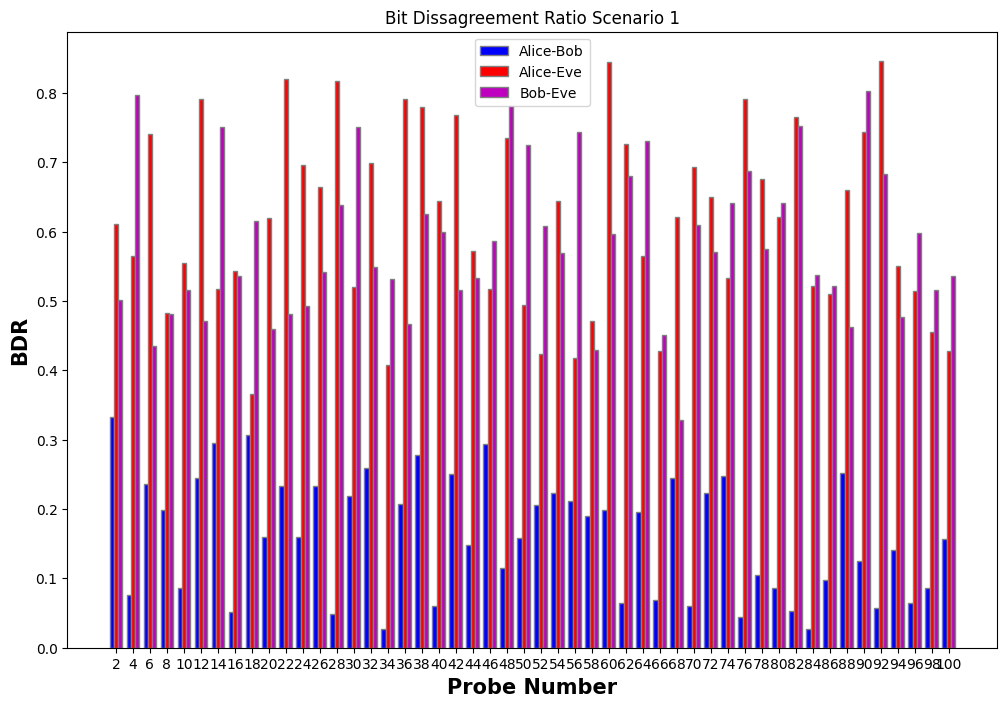

In [69]:
# KDR Bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
AB = KDR_AB_average_batch
AE = KDR_AC_average_batch
BE = KDR_BC_average_batch
 
# Set position of bar on X axis
br1 = np.arange(len(AB))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, AB, color ='b', width = barWidth,
        edgecolor ='grey', label ='Alice-Bob')
plt.bar(br2, AE, color ='r', width = barWidth,
        edgecolor ='grey', label ='Alice-Eve')
plt.bar(br3, BE, color ='m', width = barWidth,
        edgecolor ='grey', label ='Bob-Eve')
 
# Adding Xticks
plt.xlabel('Probe Number', fontweight ='bold', fontsize = 15)
plt.ylabel('BDR', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(AB))],
       np.arange(1, len(AB)+1)*batch_size)

plt.title("Bit Dissagreement Ratio Scenario 1")
plt.legend()
plt.show()

In [70]:
#Reconciliation
k = int(len(quantized_data[0])/4)

n1 = int(k+(k/1)-1)
print(n1)
s1 = int(n1-k)
t_start = time.time()
reconciliation11,reconciliation21,reconciliation31=reconciliation_rate(quantized_data,n1,k)
t_end = time.time()
print("Time for reconciliation (Alice,Bob,Eve): ", t_end-t_start)
#print(reconciliation11)

n2 = int(k+(k/2)-1)
print(n2)
s2 = int(n2-k)
t_start = time.time()
reconciliation12,reconciliation22,reconciliation32=reconciliation_rate(quantized_data,n2,k)
t_end = time.time()
print("Time for reconciliation (Alice,Bob,Eve): ", t_end-t_start)
#print(reconciliation12)

n3 = int(k+(k/3)-1)
print(n3)
s3 = int(n3-k)
t_start = time.time()
reconciliation13,reconciliation23,reconciliation33=reconciliation_rate(quantized_data,n3,k)
t_end = time.time()
print("Time for reconciliation (Alice,Bob,Eve): ", t_end-t_start)
#print(reconciliation13)

255


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 100/101.0 [02:05<00:01,  1.26s/it]


Time for reconciliation (Alice,Bob,Eve):  125.63126993179321
191


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 100/101.0 [00:29<00:00,  3.41it/s]


Time for reconciliation (Alice,Bob,Eve):  29.366375207901
169


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 100/101.0 [00:15<00:00,  6.54it/s]

Time for reconciliation (Alice,Bob,Eve):  15.296787023544312


Average reconciliation rate Alice-Bob: 0.47
Average reconciliation rate Alice-Eve: 0.0
Average reconciliation rate Bob-Eve: 0.0
Average reconciliation rate Alice-Bob: 0.2
Average reconciliation rate Alice-Eve: 0.0
Average reconciliation rate Bob-Eve: 0.0
Average reconciliation rate Alice-Bob: 0.07
Average reconciliation rate Alice-Eve: 0.0
Average reconciliation rate Bob-Eve: 0.0


Text(0.5, 1.0, 'Reconciliation Rate Bob Eve for RS(169,128)')

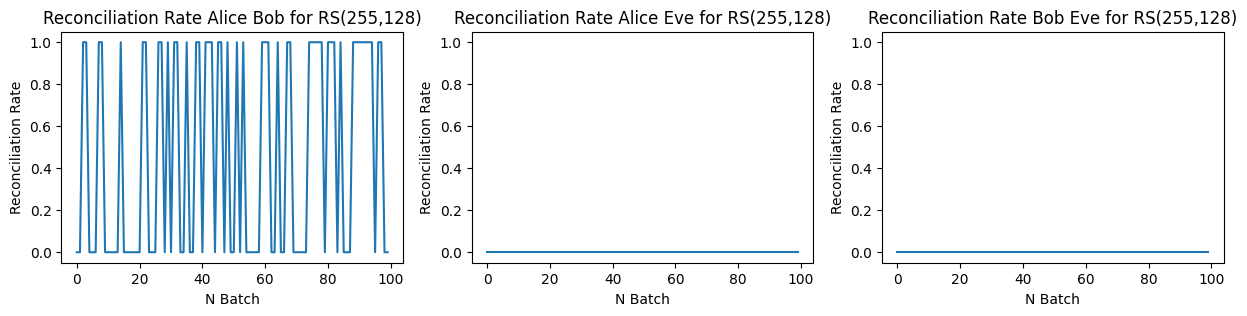

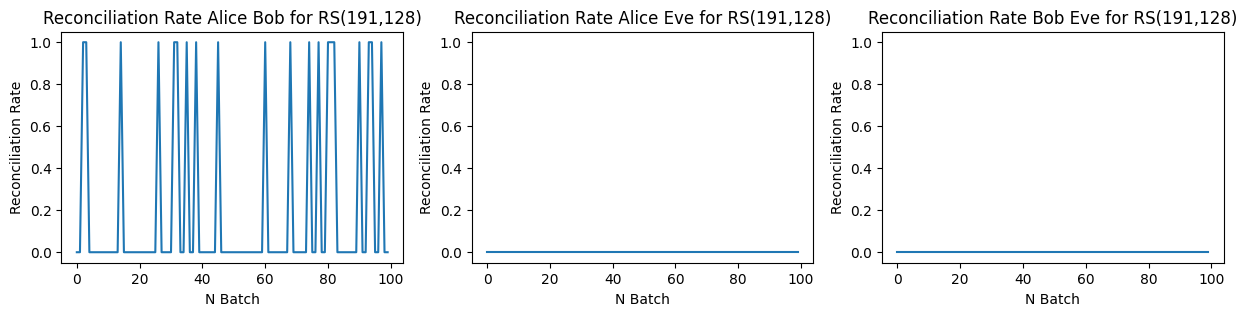

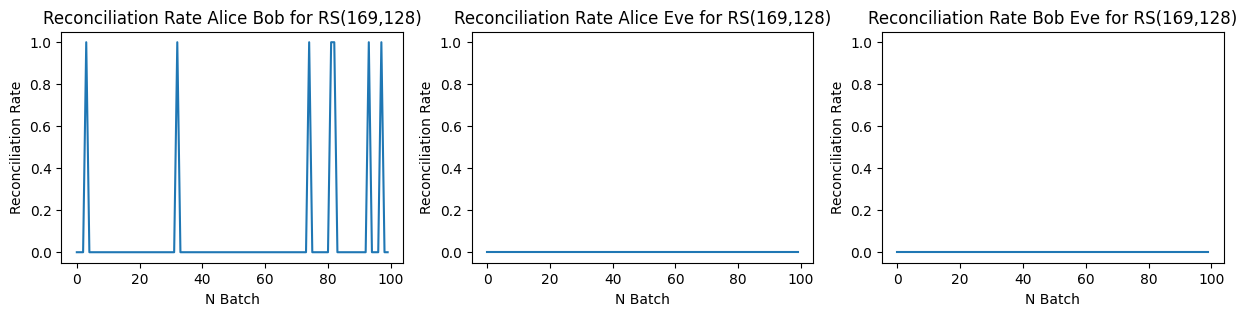

In [71]:
rec_rate_data11 = []
rec_rate_data21 = []
rec_rate_data31 = []

rec_rate_data12 = []
rec_rate_data22 = []
rec_rate_data32 = []

rec_rate_data13 = []
rec_rate_data23 = []
rec_rate_data33 = []

i = 0
while i < len(reconciliation11):
    rec_rate_data11.append(reconciliation11[i][0])
    rec_rate_data21.append(reconciliation21[i][0])
    rec_rate_data31.append(reconciliation31[i][0])
    
    rec_rate_data12.append(reconciliation12[i][0])
    rec_rate_data22.append(reconciliation22[i][0])
    rec_rate_data32.append(reconciliation32[i][0])
    
    rec_rate_data13.append(reconciliation13[i][0])
    rec_rate_data23.append(reconciliation23[i][0])
    rec_rate_data33.append(reconciliation33[i][0])
    i = i+1

rec_rate_AB_average1 = np.sum(rec_rate_data11)/(len(rec_rate_data11))
print("Average reconciliation rate Alice-Bob:", rec_rate_AB_average1)
rec_rate_AC_average1 = np.sum(rec_rate_data21)/(len(rec_rate_data21))
print("Average reconciliation rate Alice-Eve:", rec_rate_AC_average1)
rec_rate_BC_average1 = np.sum(rec_rate_data31)/(len(rec_rate_data31))
print("Average reconciliation rate Bob-Eve:", rec_rate_BC_average1)

rec_rate_AB_average2 = np.sum(rec_rate_data12)/(len(rec_rate_data12))
print("Average reconciliation rate Alice-Bob:", rec_rate_AB_average2)
rec_rate_AC_average2 = np.sum(rec_rate_data22)/(len(rec_rate_data22))
print("Average reconciliation rate Alice-Eve:", rec_rate_AC_average2)
rec_rate_BC_average2 = np.sum(rec_rate_data32)/(len(rec_rate_data32))
print("Average reconciliation rate Bob-Eve:", rec_rate_BC_average2)

rec_rate_AB_average3 = np.sum(rec_rate_data13)/(len(rec_rate_data13))
print("Average reconciliation rate Alice-Bob:", rec_rate_AB_average3)
rec_rate_AC_average3 = np.sum(rec_rate_data23)/(len(rec_rate_data23))
print("Average reconciliation rate Alice-Eve:", rec_rate_AC_average3)
rec_rate_BC_average3 = np.sum(rec_rate_data33)/(len(rec_rate_data33))
print("Average reconciliation rate Bob-Eve:", rec_rate_BC_average3)

plt.figure(figsize=[15,3])
plt.subplot(1, 3,1)
plt.plot(rec_rate_data11)
# naming the x axis
plt.xlabel('N Batch')
# naming the y axis
plt.ylabel('Reconciliation Rate')
plt.ylim(-0.05, 1.05)
plt.title("Reconciliation Rate Alice Bob for RS("+str(n1)+","+str(k)+")")

plt.subplot(1, 3,2)
plt.plot(rec_rate_data21)
# naming the x axis
plt.xlabel('N Batch')
# naming the y axis
plt.ylabel('Reconciliation Rate')
plt.ylim(-0.05, 1.05)
plt.title("Reconciliation Rate Alice Eve for RS("+str(n1)+","+str(k)+")")

plt.subplot(1, 3,3)
plt.plot(rec_rate_data31)
# naming the x axis
plt.xlabel('N Batch')
# naming the y axis
plt.ylabel('Reconciliation Rate')
plt.ylim(-0.05, 1.05)
plt.title("Reconciliation Rate Bob Eve for RS("+str(n1)+","+str(k)+")")

plt.figure(figsize=[15,3])
plt.subplot(1, 3,1)
plt.plot(rec_rate_data12)
# naming the x axis
plt.xlabel('N Batch')
# naming the y axis
plt.ylabel('Reconciliation Rate')
plt.ylim(-0.05, 1.05)
plt.title("Reconciliation Rate Alice Bob for RS("+str(n2)+","+str(k)+")")

plt.subplot(1, 3,2)
plt.plot(rec_rate_data22)
# naming the x axis
plt.xlabel('N Batch')
# naming the y axis
plt.ylabel('Reconciliation Rate')
plt.ylim(-0.05, 1.05)
plt.title("Reconciliation Rate Alice Eve for RS("+str(n2)+","+str(k)+")")

plt.subplot(1, 3,3)
plt.plot(rec_rate_data32)
# naming the x axis
plt.xlabel('N Batch')
# naming the y axis
plt.ylabel('Reconciliation Rate')
plt.ylim(-0.05, 1.05)
plt.title("Reconciliation Rate Bob Eve for RS("+str(n2)+","+str(k)+")")

plt.figure(figsize=[15,3])
plt.subplot(1, 3,1)
plt.plot(rec_rate_data13)
# naming the x axis
plt.xlabel('N Batch')
# naming the y axis
plt.ylabel('Reconciliation Rate')
plt.ylim(-0.05, 1.05)
plt.title("Reconciliation Rate Alice Bob for RS("+str(n3)+","+str(k)+")")

plt.subplot(1, 3,2)
plt.plot(rec_rate_data23)
# naming the x axis
plt.xlabel('N Batch')
# naming the y axis
plt.ylabel('Reconciliation Rate')
plt.ylim(-0.05, 1.05)
plt.title("Reconciliation Rate Alice Eve for RS("+str(n3)+","+str(k)+")")

plt.subplot(1, 3,3)
plt.plot(rec_rate_data33)
# naming the x axis
plt.xlabel('N Batch')
# naming the y axis
plt.ylabel('Reconciliation Rate')
plt.ylim(-0.05, 1.05)
plt.title("Reconciliation Rate Bob Eve for RS("+str(n3)+","+str(k)+")")

In [72]:
len(reconciliation11)
print(reconciliation11[2][0])

True


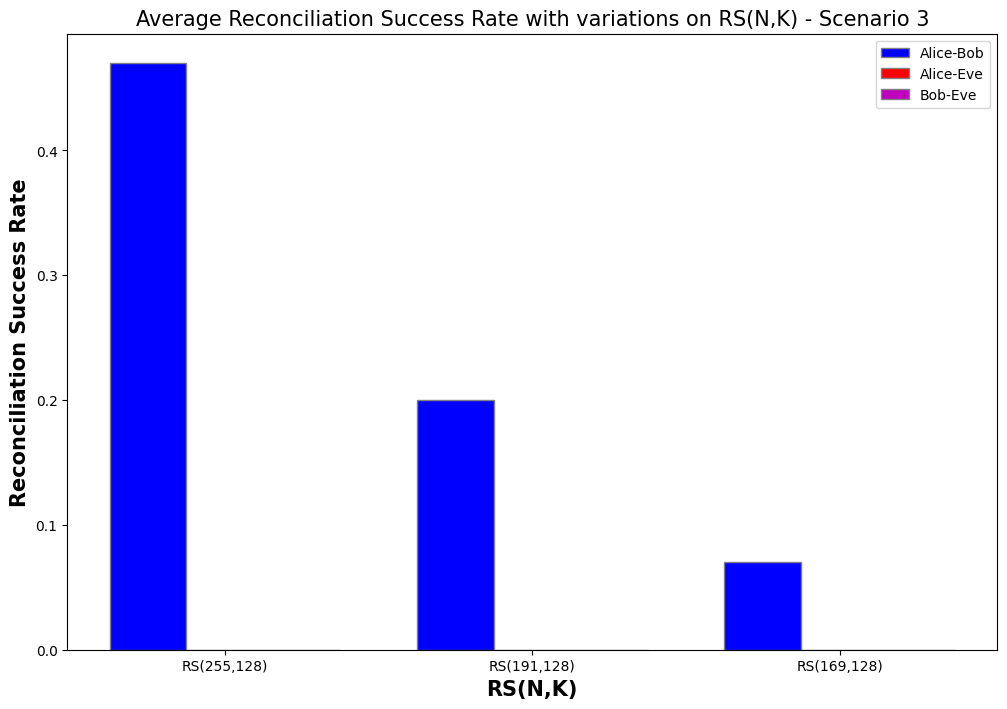

In [73]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
AB = [rec_rate_AB_average1, rec_rate_AB_average2, rec_rate_AB_average3]
AE = [rec_rate_AC_average1, rec_rate_AC_average2, rec_rate_AC_average3]
BE = [rec_rate_BC_average1, rec_rate_BC_average2, rec_rate_BC_average3]

# Set position of bar on X axis
br1 = np.arange(len(AB))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, AB, color ='b', width = barWidth,
        edgecolor ='grey', label ='Alice-Bob')
plt.bar(br2, AE, color ='r', width = barWidth,
        edgecolor ='grey', label ='Alice-Eve')
plt.bar(br3, BE, color ='m', width = barWidth,
        edgecolor ='grey', label ='Bob-Eve')
 
# Adding Xticks
plt.xlabel('RS(N,K)', fontweight ='bold', fontsize = 15)
plt.ylabel('Reconciliation Success Rate', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(AB))],
        ["RS("+str(n1)+","+str(k)+")", "RS("+str(n2)+","+str(k)+")", "RS("+str(n3)+","+str(k)+")"])

plt.title("Average Reconciliation Success Rate with variations on RS(N,K) - Scenario 3", fontsize = 15)
plt.legend()
plt.show()

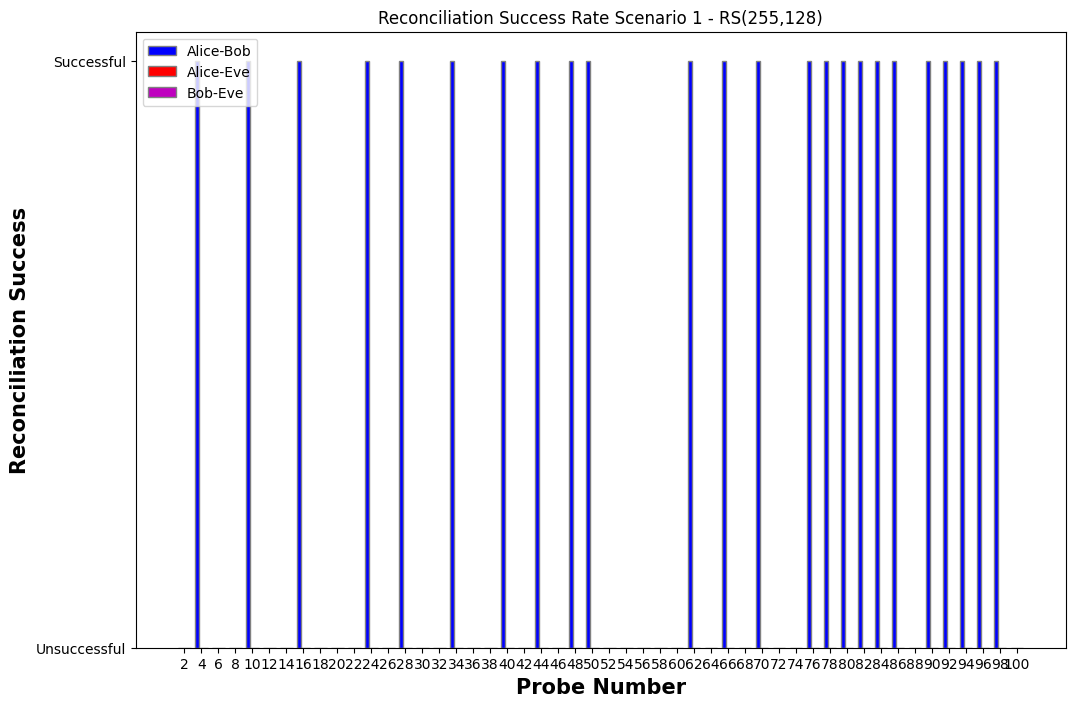

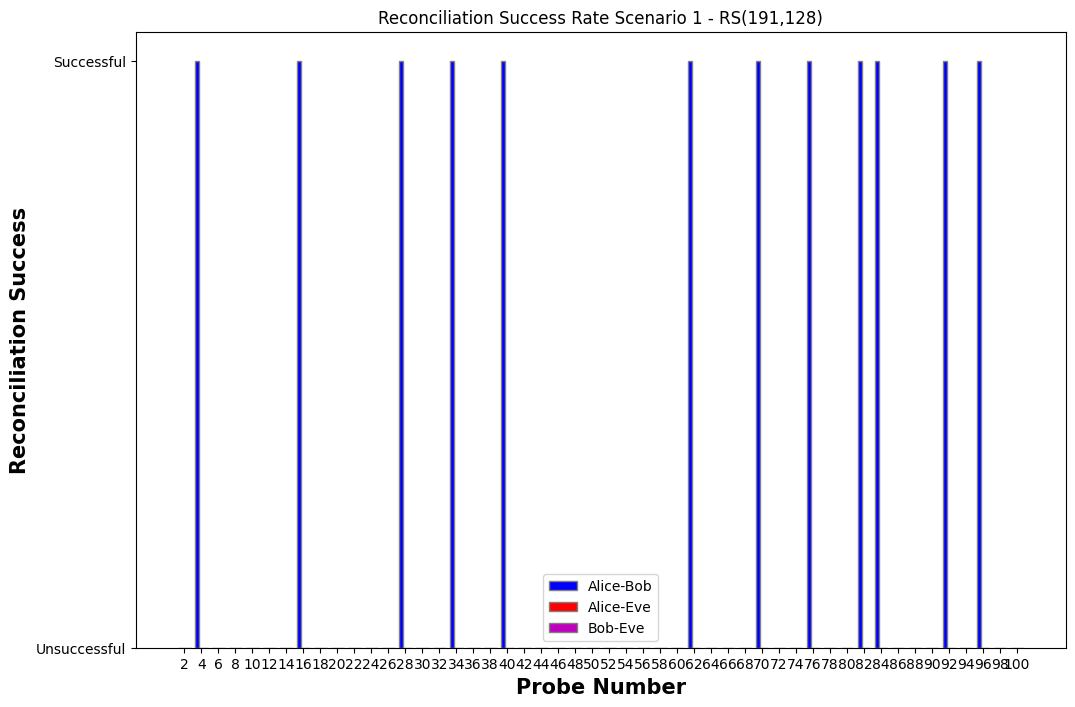

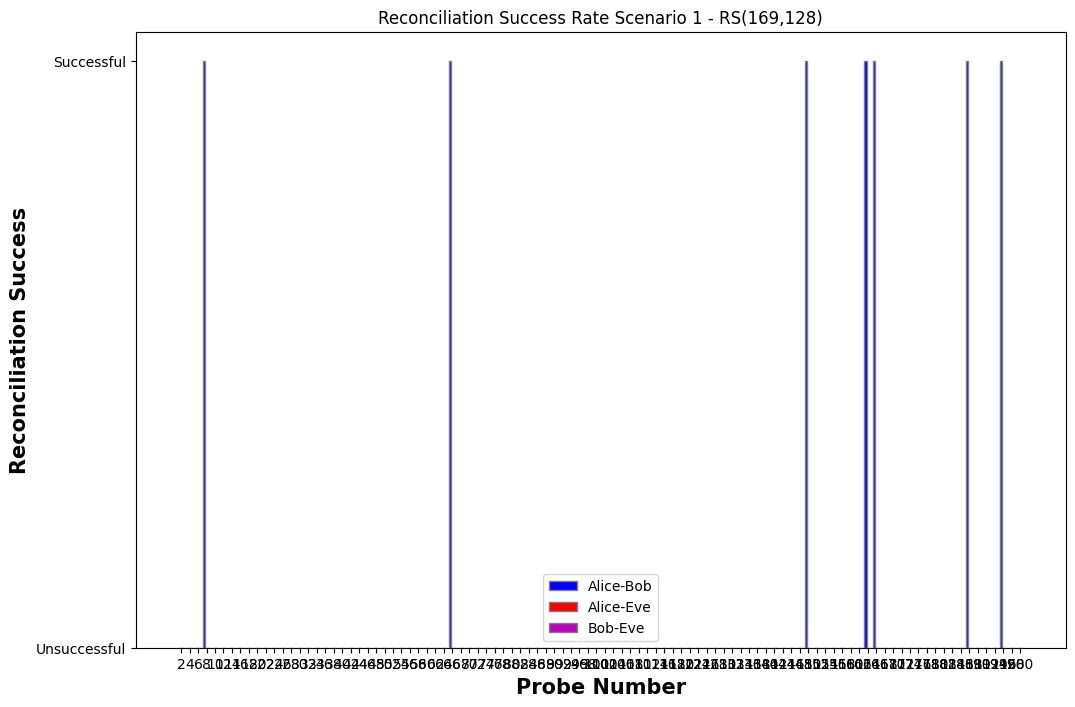

In [74]:
# Reconciliation Bar 1
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
AB = groupAverage(rec_rate_data11,batch_size)
AE = groupAverage(rec_rate_data21,batch_size)
BE = groupAverage(rec_rate_data31,batch_size)
 
# Set position of bar on X axis
br1 = np.arange(len(AB))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, AB, color ='b', width = barWidth,
        edgecolor ='grey', label ='Alice-Bob')
plt.bar(br2, AE, color ='r', width = barWidth,
        edgecolor ='grey', label ='Alice-Eve')
plt.bar(br3, BE, color ='m', width = barWidth,
        edgecolor ='grey', label ='Bob-Eve')
 
# Adding Xticks
plt.xlabel('Probe Number', fontweight ='bold', fontsize = 15)
plt.ylabel('Reconciliation Success', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(AB))],
       np.arange(1, len(AB)+1)*batch_size)
plt.yticks([0,1],["Unsuccessful", "Successful"]) 

plt.title("Reconciliation Success Rate Scenario 1 - RS("+str(n1)+","+str(k)+")")
plt.legend()
plt.show()

# Reconciliation Bar 2
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
AB = groupAverage(rec_rate_data12,batch_size)
AE = groupAverage(rec_rate_data22,batch_size)
BE = groupAverage(rec_rate_data32,batch_size)
 
# Set position of bar on X axis
br1 = np.arange(len(AB))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, AB, color ='b', width = barWidth,
        edgecolor ='grey', label ='Alice-Bob')
plt.bar(br2, AE, color ='r', width = barWidth,
        edgecolor ='grey', label ='Alice-Eve')
plt.bar(br3, BE, color ='m', width = barWidth,
        edgecolor ='grey', label ='Bob-Eve')
 
# Adding Xticks
plt.xlabel('Probe Number', fontweight ='bold', fontsize = 15)
plt.ylabel('Reconciliation Success', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(AB))],
       np.arange(1, len(AB)+1)*batch_size)
plt.yticks([0,1],["Unsuccessful", "Successful"]) 

plt.title("Reconciliation Success Rate Scenario 1 - RS("+str(n2)+","+str(k)+")")
plt.legend()
plt.show()


# Reconciliation Bar 3
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
AB = groupAverage(rec_rate_data13,1)
AE = groupAverage(rec_rate_data23,1)
BE = groupAverage(rec_rate_data33,1)
 
# Set position of bar on X axis
br1 = np.arange(len(AB))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, AB, color ='b', width = barWidth,
        edgecolor ='grey', label ='Alice-Bob')
plt.bar(br2, AE, color ='r', width = barWidth,
        edgecolor ='grey', label ='Alice-Eve')
plt.bar(br3, BE, color ='m', width = barWidth,
        edgecolor ='grey', label ='Bob-Eve')
 
# Adding Xticks
plt.xlabel('Probe Number', fontweight ='bold', fontsize = 15)
plt.ylabel('Reconciliation Success', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(AB))],
       np.arange(1, len(AB)+1)*batch_size)
plt.yticks([0,1],["Unsuccessful", "Successful"]) 

plt.title("Reconciliation Success Rate Scenario 1 - RS("+str(n3)+","+str(k)+")")
plt.legend()
plt.show()

In [30]:
#Privacy Amplification
priv_amp_data = []
i = 0
rec_data1 = np.array(reconciliation11)
t_start = time.time()
while i < rec_data1.shape[0]:
    priv_amp = privacyAmplification(rec_data1[i][1])
    priv_amp_data.append(priv_amp)
    i = i+1
t_end = time.time()
print("Time for privacy amplification: ", t_end-t_start)
#print(priv_amp_data)

Time for privacy amplification:  0.0020952224731445312


[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 

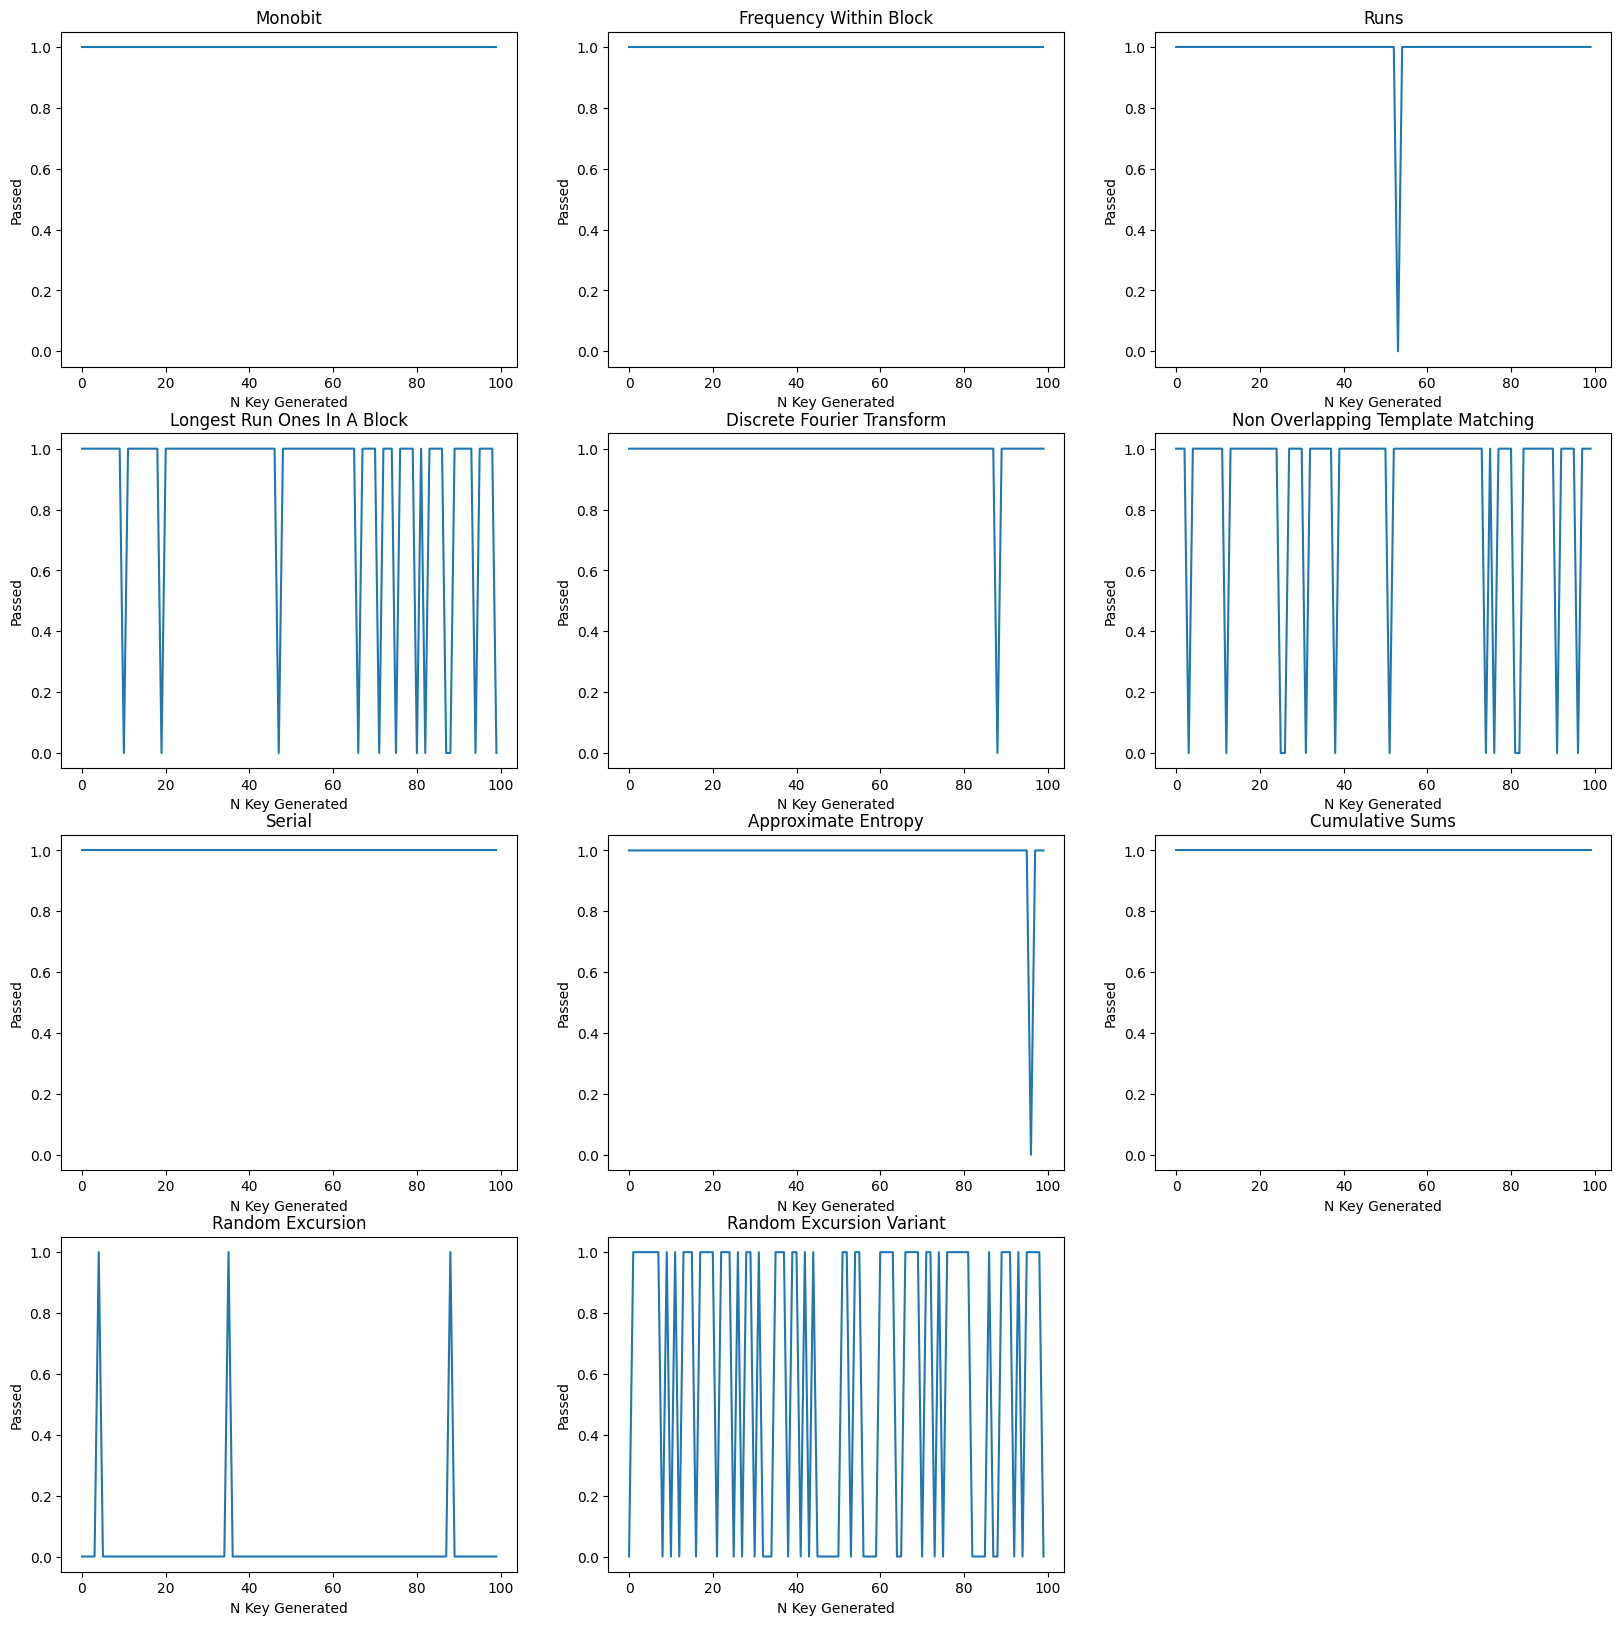

In [31]:
#NIST Test Suite for Random and Pseudorandom Number Generators for Cryptographic Applications
priv_amp_bin_data = []

for P_A_data in priv_amp_data:
    priv_amp_bin = str2arr(P_A_data)
    priv_amp_bin_data.append(priv_amp_bin)

print(priv_amp_bin_data[0])

NIST_RNG_test(priv_amp_bin_data)

In [32]:
A=[1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
B=[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]

In [34]:
print(KDR(A,B))


def reconcile(A,B,n=255,k=128):
    A = hex(int(arr2str(A), 2))
    A = str(A[2:]) #A hex key
    B = hex(int(arr2str(B), 2))
    B = str(B[2:]) #B hex key
    coder = rs.RSCoder(n,k)
    Aencode = coder.encode(A) #Encode A
    Aparity = Aencode[k:] #A parity bits
    BAparity = B+Aparity #B key + A parity bits
    try:
        Bdecode = coder.decode(BAparity) #Decode B key + A parity bits
        Breconciled = Bdecode[0] #Reconcilieted key
    except:
        Breconciled = B
    return [A == Breconciled,Breconciled]

reconcile(A,B)

0.23828125


[False,
 'f42a1cb522ed9676d23a65d97f3ea88a2c51fb9e5e31ee2e89abb39a567af9377e3022689384b18e21285d1522484b0d52a2658f5bfeec810b3f02ccd2eb4ca4']

In [35]:
def create_parity_bits(key,n=255,k=128):
    key = hex(int(arr2str(key), 2))
    key = str(key[2:]) #A hex key
    coder = rs.RSCoder(n,k)
    key_encode = coder.encode(key) #Encode A
    key_parity = key_encode[k:] #A parity bits
    return key_parity

parity_bits = create_parity_bits(A,n=255,k=128)
print(parity_bits)
# Convert the string to bytes
byte_data = parity_bits.encode('latin1')  # 'latin1' is used to handle extended ASCII
print("byte_data:", byte_data)
# Convert bytes to hex
hex_representation = byte_data.hex()
print("Hex:", hex_representation)
hex_string = str(hex_representation)
#hex_form = "0x" + hex_string
# Hex to bytes
byte_data_from_hex = bytes.fromhex(hex_string)

original_data_from_hex = byte_data_from_hex.decode('latin1')

print("From Hex:", original_data_from_hex)

print(original_data_from_hex==parity_bits)

@Ñ DÊRÜµÔæçêZl¡	§B÷fºrÓGùßlzÏ;G\¥2WHÜ»ùð0y²m~Y¼k<üTnQÞDÒ¢  6j\¯É60CÕoú×RÓ}rQÊÃç[»554v
byte_data: b'@\xd1\xa0D\xca\x96R\xdc\xb5\xd4\x81\x97\xe6\xe7\xea\x02Zl\xa1\t\xa7B\x16\xf7f\x1e\xbar\xd3\x99G\xed\x08\xf9\xdfl\x92\x95z\x8c\xcf;\x14\x93\x95G\\\xa52WH\xdc\x87\x8ct\x08\xbb\x10\xf9\xf00y\x8b\xb2m\x84\x0c~Y\x1a\xbck<\xfcTn\x98Q\xdeD\x06\xd2\xa2\x9e\x00\x006j\x1c\\\xaf\xc9\x01\x9b60\x0e\x83C\x96\xd5o\xfa\x06(\x08\x8c\xd7R\xd3\x01}rQ\xca\xc3\xe7[\xbb\x8a55\x8b\x154v\x94'
Hex: 40d1a044ca9652dcb5d48197e6e7ea025a6ca109a74216f7661eba72d39947ed08f9df6c92957a8ccf3b149395475ca5325748dc878c7408bb10f9f030798bb26d840c7e591abc6b3cfc546e9851de4406d2a29e0000366a1c5cafc9019b36300e834396d56ffa0628088cd752d3017d7251cac3e75bbb8a35358b15347694
From Hex: @Ñ DÊRÜµÔæçêZl¡	§B÷fºrÓGùßlzÏ;G\¥2WHÜ»ùð0y²m~Y¼k<üTnQÞDÒ¢  6j\¯É60CÕoú×RÓ}rQÊÃç[»554v
True


In [36]:
#Reconciliation

def reconcile_parity(key,parity,n=255,k=128):
    key = hex(int(arr2str(key), 2))
    key = str(key[2:]) #B hex key
    key_parity = key+parity #B key + A parity bits
    coder = rs.RSCoder(n,k)
    reconciled = False
    try:
        key_decode = coder.decode(key_parity) #Decode B key + A parity bits
        key_reconciled = key_decode[0] #Reconcilieted key
        reconciled = True
    except:
        key_reconciled = key
    return reconciled,key_reconciled

result,key_reconciled = reconcile_parity(B,parity_bits,n=255,k=128)
print(result)



False
